# Equilibrage des classes

le dataset présente un déséquilibre avec une très large majorité de classe 0 (normal). 

On regarde comment augmenter le nombre de classe non 0

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from scipy import signal, interpolate
from scipy.ndimage import gaussian_filter
from imblearn.over_sampling import SMOTE

In [2]:
folder = '../data/raw'
df = pd.read_csv(os.path.join(folder,'mitbih_train.csv'),header=None)


In [3]:
target = df.pop(df.columns[-1])
dict_target = {0: 'Normal',
               1:'Supraventricular premature beat',
               2:'Premature ventricular contraction',
               3:'Fusion of ventricular and normal beat',
              4: 'Unclassifiable beat'}
target_str = target.replace(dict_target)

In [4]:
X = np.array(df)
y = np.array(target)

187
Normal                                   72471
Unclassifiable beat                       6431
Premature ventricular contraction         5788
Supraventricular premature beat           2223
Fusion of ventricular and normal beat      641
Name: count, dtype: int64


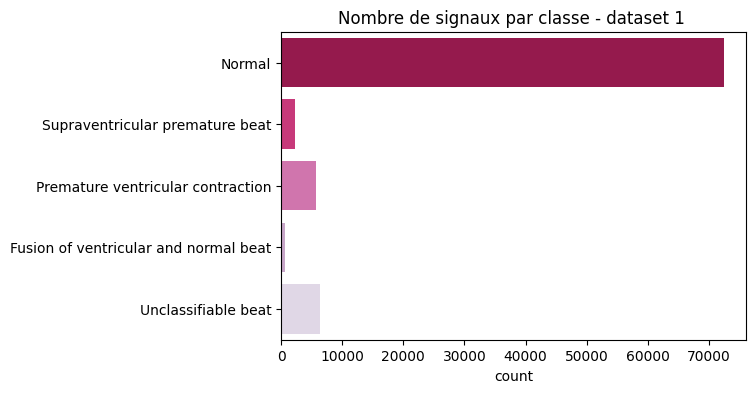

In [5]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot()
sns.countplot(y=target_str,ax=ax,hue=target_str,palette='PuRd_r',orient='v')
ax.set_title('Nombre de signaux par classe - dataset 1 ')
ax.set_ylabel('')
print(target_str.value_counts())

## Augmentation des classes 1,2,3,3 - Methode 1

Comme nous ne sommes pas experts du domaine, il est difficile de connaitre les raisons de la classification d'un ECG. les perturbations appliquées doivent être faibles pour ne pas compromettre le signal
les modifications suivantes sont appliquées:
* augmentation de quelques points du signap par étirage ou compression
* application d'une trend lineaire, de pente aléatoire
* mise à une puissance x**y

puis renormalisation du signal

### fonction d'augmentations

In [6]:
def signal_temporal_trend(x,m,no_change_index):
    # applique une trend lineaire au signal . au point no_change_index, le coef vaut 1 
    # la pente de la trend est m
    coef = m/no_change_index*np.arange(x.shape[0])+1+m
    return coef*x

def augment(x):
    # p : mise a la puissance p
    p = np.random.uniform(low=0.85, high=1.15)
    # c : application d'une trend lineaire, au point c, la trend vaut 1
    c = int(np.random.uniform(low=20,high=160))
    c=93
    # pente de la trend
    m = np.random.uniform(low=-0.1,high=0.1)
    # applique une puissance au signal
    a = signal_temporal_trend(x,m,c)**p
    a = a/(max(a)-min(a))
    
    # streching
    Nadd = np.random.randint(low=-5,high=5)
    if Nadd !=0:
        f = interpolate.interp1d(np.arange(0, x.shape[0]), a)
        a = f(np.linspace(0.0, x.shape[0]-1, x.shape[0]+Nadd))
    if Nadd<0:
        b = np.zeros(shape=(x.shape[0], ))
        b[0:x.shape[0]+Nadd] = a
        a = b
    else:        
        a = a[0:x.shape[0]]
    return a

### examples

In [7]:
def show_augmented(x,N):
    """
        inputs :
        ------------
        x : np.array 1 dimension = temporal signal
        N : int number of signals to build from x
    """
    
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot()
    t = np.arange(x.shape[0])/125
    for k in range(20):
        ax.plot(t,augment(x),color='deepskyblue')
    ax.plot(t,x,color='k')
    ax.set_title('Black: original, blue: augmented')

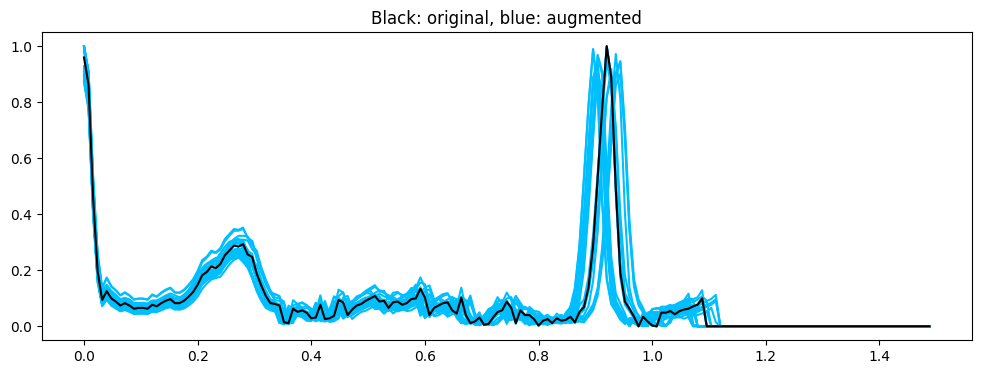

In [8]:
show_augmented(X[1,:],20)

signal # [69718] classe  0


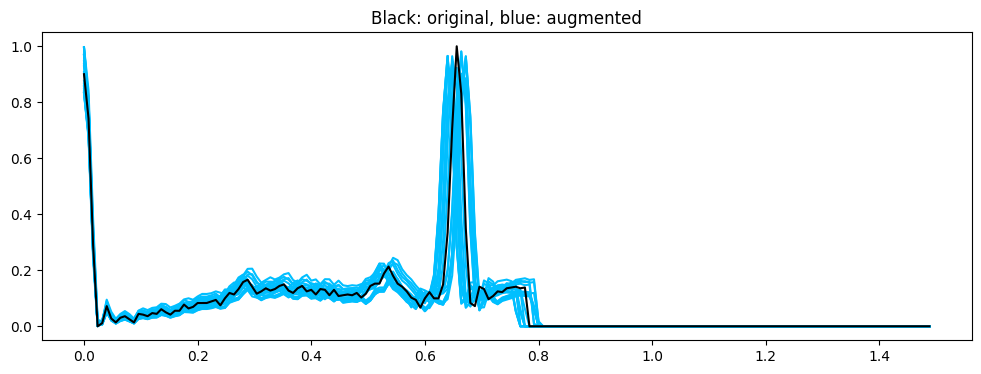

signal # [72925] classe  1


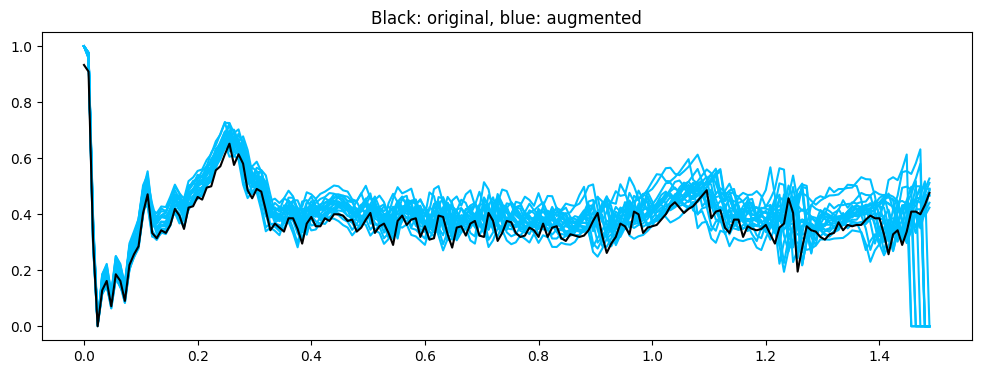

signal # [74887] classe  2


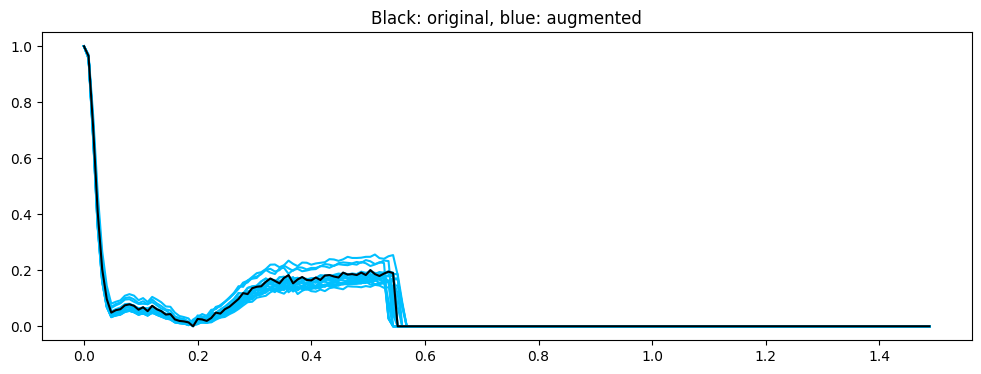

signal # [80801] classe  3


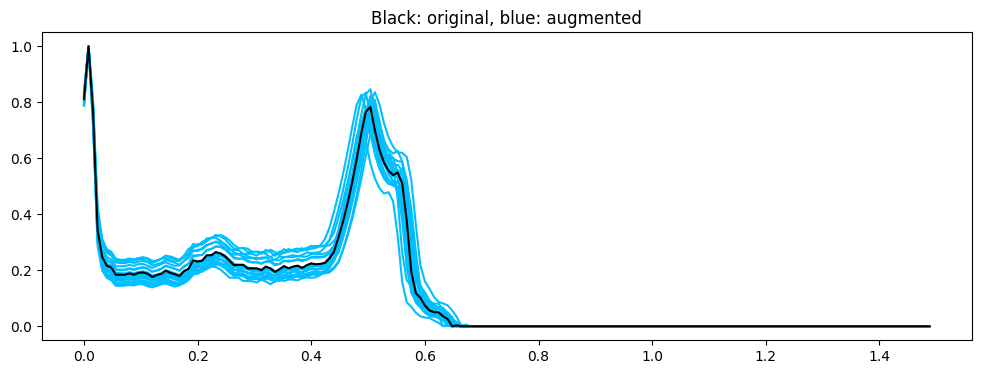

signal # [83514] classe  4


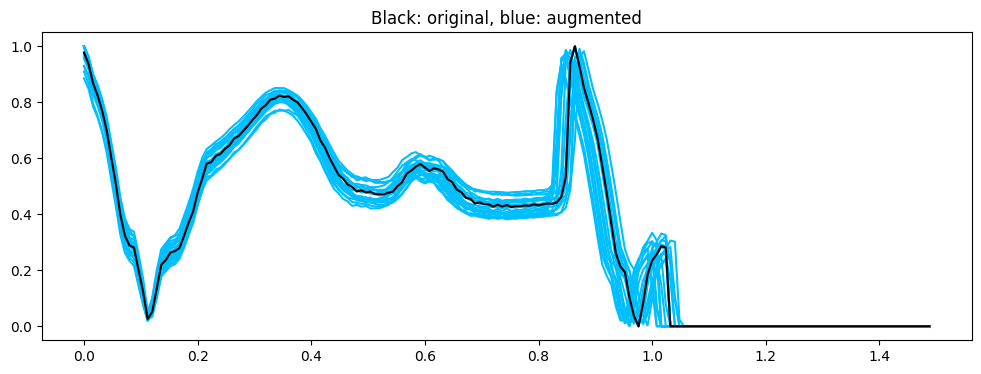

In [9]:

for classe in range(5):
    ii = np.random.choice([i for i, x in enumerate(target==classe) if x],1) 
    print('signal #',ii,'classe ',classe)
    show_augmented(X[ii[0],:],20)
    plt.show()

## Methode 2 -SMOTE

Test pour voir s'il ne fait pas n'impoirte quoi avec des signaux temporels. Le problème étant qu'on ne peut pas trop voir les signaux nouveaux et les anciens signaux

### Test sur une petite base

In [10]:
nperclasse = [400,30,40,20,40]
ii = []
for classe in range(5):
    ii += list(np.random.choice([i for i, x in enumerate(y) if x==classe],nperclasse[classe]))
Xsub = X[ii,:]
ysub = y[ii]



In [11]:

sm = SMOTE(random_state=42,sampling_strategy='not majority')
X_sm, y_sm = sm.fit_resample(Xsub ,ysub)


class  1  now size  400
class  2  now size  400
class  3  now size  400
class  4  now size  400


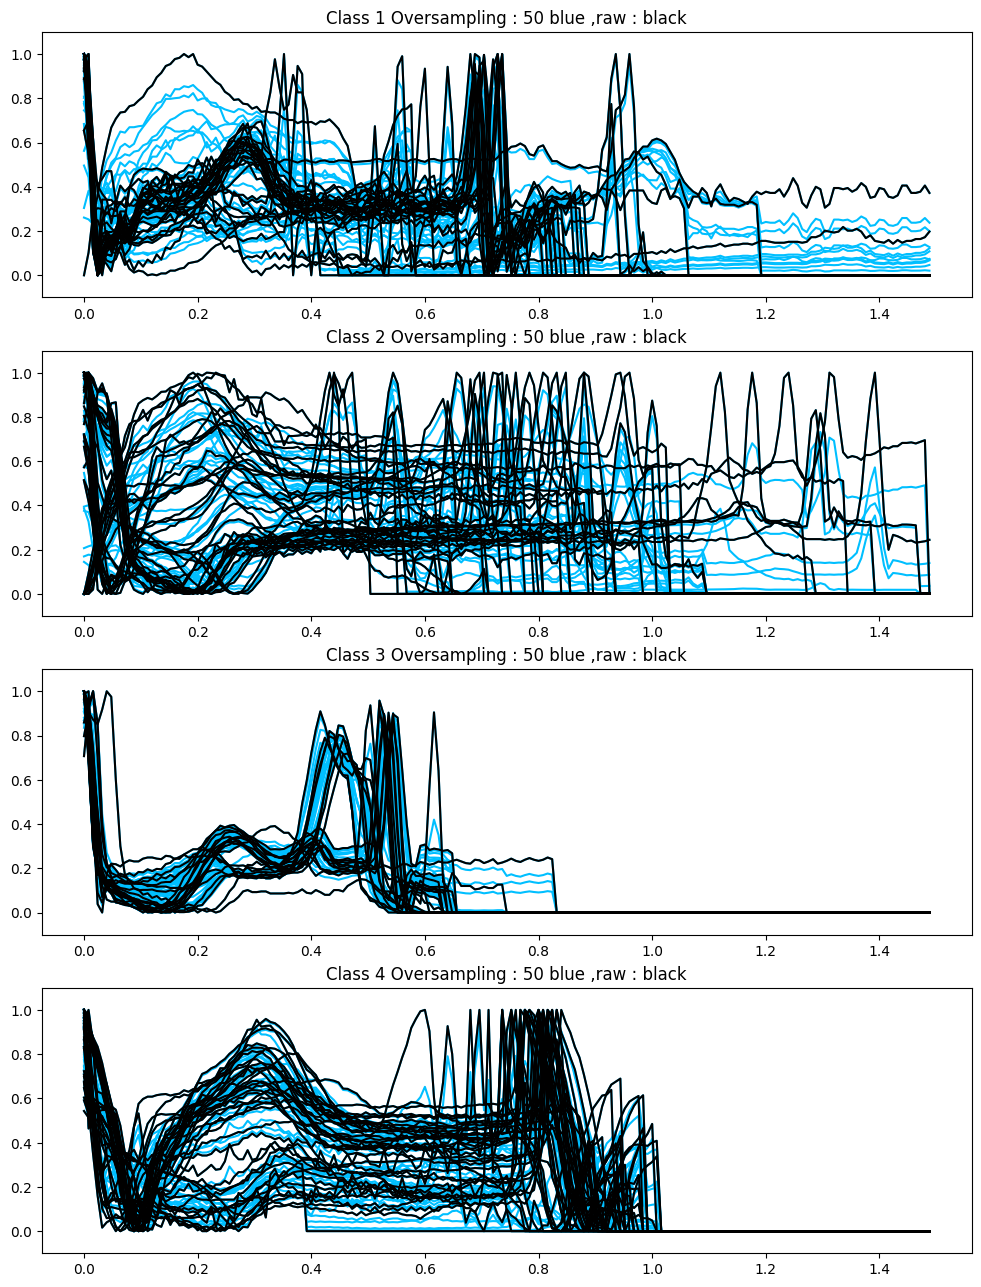

In [12]:
fig = plt.figure(figsize=(12,20))
for classe in range(1,5):
       

    Xraw = Xsub[ysub == classe,:]
    X_sm4 = X_sm[y_sm == classe,:]
    ax = fig.add_subplot(510+classe)
    t = np.arange(Xraw.shape[1])/125
    
    print('class ',classe,' now size ',X_sm4.shape[0])
    for k in range(100):
        ax.plot(t,X_sm4[k,:],color='deepskyblue')

    for k in range(Xraw.shape[0]):
            ax.plot(t,Xraw[k,:],color='k')
    ax.set_title('Class %d Oversampling : 50 blue ,raw : black' %classe)
    ax.set_ylim([-0.1,1.1])

## Conclusion

le smote n'a pas l'air de mettre des échantillons abérrants.C'est pas si mal. y en a quand même des bizarres
On fait méthodes d'augmentation. on pourra tester les modèles sur :
* base smote
* base signal augmentée
* la concatenation des deux methodes


### Fonction de data augmentation

In [13]:
def augmentbase_shape(X_data,y_data,n_per_class):
    X2 = None
    y2 = None
    npts = X_data.shape[1]
    print(np.unique(y_data))
    for classe in np.unique(y_data):
        # indices des signaux de classe "classe"
        index_of_class = [k for k,x in enumerate(y_data) if x==classe]
        if len(index_of_class) > n_per_class:
            print('class ',classe,' undersampling')
            np.random.shuffle(index_of_class)
            DataAdd = X_data[index_of_class[0:n_per_class],:]
            Yadd = y_data[index_of_class[0:n_per_class]]       
        else:
            Nmissing = n_per_class-len(index_of_class)
            print('class ',classe,' undersampling, missing ',Nmissing)
            ii = np.random.choice(index_of_class,Nmissing)
            data_temp = np.zeros((Nmissing,npts))
            for kk,jj in enumerate(ii):
                data_temp[kk,:] = augment(X_data[jj,:])
                
            DataAdd = np.concatenate((X_data[index_of_class,:],data_temp),axis=0)
            Yadd =  np.ones(DataAdd.shape[0])*classe
            print('class ',classe,' add ', data_temp.shape[0],'new shape',DataAdd.shape[0],',',Yadd.shape[0])
       
        if X2 is None:
            X2 = DataAdd
            y2 = Yadd
        else:
            X2 = np.concatenate((X2,DataAdd),axis=0)
            y2 =np.concatenate((y2,Yadd))
    return X2,y2

def augmentbase_smote(X_data,y_data):
    sm = SMOTE(random_state=42,sampling_strategy='not majority') 
    X_sm, y_sm = sm.fit_resample(X_data ,y_data)
    return X_sm,y_sm

### Test


Division de la base en 2 parties de 6000 signaux normaux.
A chaque partie, on ajoute les autres classes

In [14]:
i0 = [k for k,x in enumerate(y) if x==0]
np.random.shuffle(i0)
Nsmote = 6000
base_1 = i0[0:Nsmote]
base_2 = i0[Nsmote::]

for classe in range(1,5):
    index_of_class = [k for k,x in enumerate(y) if x==classe]
    base_1 += index_of_class
    base_2 += index_of_class

### augmentation par les deux méthodes des 2 bases

In [15]:
X1,y1 = augmentbase_smote(X[base_1,:],y[base_1])
X2,y2 = augmentbase_shape(X[base_2,:],y[base_2],6000)


[0. 1. 2. 3. 4.]
class  0.0  undersampling
class  1.0  undersampling, missing  3777
class  1.0  add  3777 new shape 6000 , 6000
class  2.0  undersampling, missing  212
class  2.0  add  212 new shape 6000 , 6000
class  3.0  undersampling, missing  5359
class  3.0  add  5359 new shape 6000 , 6000
class  4.0  undersampling


In [16]:
print('raw')
print(pd.Series(y[base_1]).value_counts())
print('smote')
print(pd.Series(y1).value_counts())


raw
4.0    6431
0.0    6000
2.0    5788
1.0    2223
3.0     641
Name: count, dtype: int64
smote
0.0    6431
1.0    6431
2.0    6431
3.0    6431
4.0    6431
Name: count, dtype: int64


In [17]:
X3 = np.concatenate((X1,X2),axis=0)
y3 =np.concatenate((y1,y2))

### bases créées


Text(0, 0.5, '')

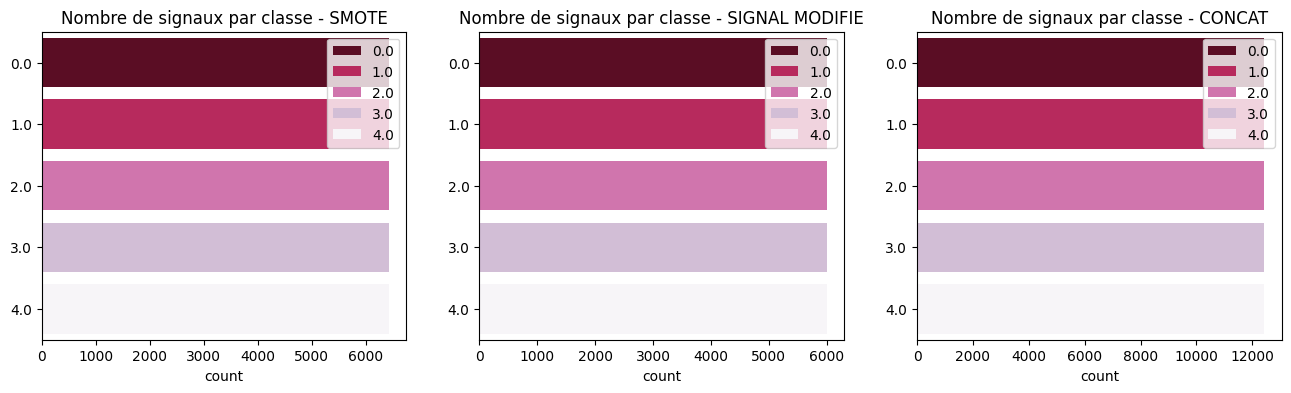

In [18]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(131)
sns.countplot(y=y1,ax=ax,hue=y1,palette='PuRd_r',orient='v')
ax.set_title('Nombre de signaux par classe - SMOTE')
ax.set_ylabel('')
ax = fig.add_subplot(132)
sns.countplot(y=y2,ax=ax,hue=y2,palette='PuRd_r',orient='v')
ax.set_title('Nombre de signaux par classe - SIGNAL MODIFIE')
ax.set_ylabel('')
ax = fig.add_subplot(133)
sns.countplot(y=y3,ax=ax,hue=y3,palette='PuRd_r',orient='v')
ax.set_title('Nombre de signaux par classe - CONCAT')
ax.set_ylabel('')